In [ ]:
# import necesarry packages

import numpy as np
import scipy.stats as ss
from time import time

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline

import seaborn as sns
sns.set()

## Slice Sampling

### Idea

The single variable slice sampling method replaces the current value,$x_0$, with a new variable $x_1$, found by a three step procesdure as follows:

1. Draw $y\sim\text{Uniform}\left(0,f\left(x_{0}\right)\right)$ to define the horizontal slice $S=\left\{ x:y<f\left(x\right)\right\}$. Note that $x_0$ is always within $S$.
2. Find the interval $I=\left(L, R\right)$ around $x_0$ that contains at least a big part of the slice.
3. Draw the new point $x_1$ from the part of the slice within the interval which is $S\cap I$.

### Finding the appropriate interval
The interval in step 2 $I=\left(L, R\right)$ needs to contain as much of the slice as feasible to allow the new point to differ as much as possible from the previous point. But on the other hand, we don't want it to be much larger than the slice, because it will results to less efrficient sampling. We usually use an estimation $w$ for the scale of $S$ and randomly pick an initial interval of wise $w$ around $x_0$ and then expand it. if it is stepping out it is enouhj to be in the 
if it is doubling it should ne checked.

### sampling from the interval


In [ ]:
def I_stepping_out(f, x0, w=1, m=1000):
    """
    stepping out procedure for finding an appropriate interval around
    the current point    
    """
    
    y0 = f(x0)
    y = np.random.uniform(0, y0)
    U = np.random.uniform(0, 1)
    L = x0 - U*w
    R = L + w

    V = np.random.uniform(0, 1)
    J = np.floor(m*V)
    K = (m-1) - J

    while J>0 and y<f(L):
        L = L - w
        J = J - 1
    while K>0 and y<f(R):
        R = R + w
        K = K - 1   
        
    return L, R, y

def I_doubling(f, x0, w=1, p=20):
    """
    doubling procedure for finding an appropriate interval around 
    the current point
    """

    y0 = f(x0)
    y = np.random.uniform(0, y0)
    U = np.random.uniform(0, 1)
    L = x0 - w*U
    R = L + w
    K = p

    while K>0 and (y<f(L) or y<f(R)):
        V = np.random.uniform(0, 1)
        if V<0.5:
            L = L - (R - L)
        else:
            R = R + (R - L)
        K = K - 1
        
    return L, R, y

def accept_doubling(f, x0, x1, y, w, L, R):
    """
    checks if the proposal is acceptable or not
    """
    D = False
    while (R - L) > 1.1*w:
        M = (R + L) / 2
        if (x0<M and x1>=M) or (x0>=M and x1<M):
            D = True
        if x1 < M:
            R = M
        else:
            L = M
        if D and y>=f(L) and y>=f(R):
            return False
    return True  

def slice_sampler_stepping_out(f, n_samples, x0, w, m):
    
    samples = np.zeros(n_samples)
    for i in xrange(n_samples):
        while(True):
            L, R, y = I_stepping_out(f, x0, w, m)
            x1 = np.random.uniform(L, R)

            if f(x1) > y:
                break
            if x1 < x0:
                L = x1
            else:
                R = x1
        x0 = x1
        samples[i] = x0
    
    return samples


def slice_sampler_doubling(f, n_samples, x0, w, p):
    
    samples = np.zeros(n_samples)
    
    for i in xrange(n_samples):
        while(True):
            L, R, y = I_doubling(f, x0, w, p)
            x1 = np.random.uniform(L, R)

            if f(x1) > y and accept_doubling(f, x0, x1, y, w, L, R):
                break
            if x1 < x0:
                L = x1
            else:
                R = x1
        x0 = x1
        samples[i] = x0
    return samples

def slice_sampler(f, n_samples, x0, w, doubling=True, m=50, p=20):
    if doubling:
        return slice_sampler_doubling(f, n_samples, x0, w, p)
    else:
        return slice_sampler_stepping_out(f, n_samples, x0, w, m)

In [ ]:
# Plotting the interval I 

f = ss.norm.pdf
x0 = 1
w = 0.5
m = 100
p = 50

L1, R1, y1 = I_stepping_out(f, x0, w, m)
L2, R2, y2 = I_doubling(f, x0, w, p)


X = np.linspace(-4, 4, 100)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].plot(X, f(X))
axes[1].plot(X, f(X))

axes[0].hlines(y1, L1, R1, lw=2)
axes[0].plot(x0, y1, 'o', label='x0')
axes[1].hlines(y2, L2, R2, lw=2)
axes[1].plot(x0, y2, 'o', label='x0')

axes[0].set_title("stepping out procedure, w={}, m={}".format(w, m))
axes[1].set_title("doubling procedure, w={}, p={}".format(w, p))
axes[0].legend()
axes[1].legend()

### Unimodal densities

In [ ]:
f = ss.norm.pdf

n_samples = 1000
x0 = 0
w = 0.5
m = 50
p = 20

samples1 = slice_sampler(f, n_samples, x0, w=w, m=m, doubling=False)    # stepping out
samples2 = slice_sampler(f, n_samples, x0, w=w, p=p, doubling=True)     # doubling

In [ ]:
# visualization
X = np.linspace(-5, 5, 100)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].hist(samples1, bins=20, normed=True)
axes[0].plot(X, f(X))
axes[0].set_title("stepping out technique, w={}, n_samples={}".format(w, n_samples))
axes[1].hist(samples2, bins=20, normed=True)
axes[1].plot(X, f(X))
axes[1].set_title("doubling technique, w={}, n_samples={}".format(w, n_samples))

# Multimodal densities

In [ ]:
mu1 = 3
mu2 = 10
sigma1 = 1
sigma2 = 2
m1 = 0.2
m2 = 0.8

f = lambda x: m1 * ss.norm.pdf(x, mu1, sigma1) + m2 * ss.norm.pdf(x, mu2, sigma2)

In [ ]:
# Plotting the interval I 

x0 = 1
w = 0.5
m = 500
p = 50

L1, R1, y1 = I_stepping_out(f, x0, w, m)
L2, R2, y2 = I_doubling(f, x0, w, p)

X = np.linspace(-5, 20, 100)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].plot(X, f(X))
axes[1].plot(X, f(X))

axes[0].hlines(y1, L1, R1, lw=2)
axes[0].plot(x0, y1, 'o', label='x0')
axes[1].hlines(y2, L2, R2, lw=2)
axes[1].plot(x0, y2, 'o', label='x0')

axes[0].set_title("stepping out procedure, w={}, m={}".format(w, m))
axes[1].set_title("doubling procedure, w={}, p={}".format(w, p))
axes[0].legend()
axes[1].legend()

In [ ]:
n_samples = 1000
x0 = 0
w = 0.5
m = 50
p = 20

samples1 = slice_sampler(f, n_samples, x0, w=w, m=m, doubling=False)    # stepping out
samples2 = slice_sampler(f, n_samples, x0, w=w, p=p, doubling=True)     # doubling

# visualization
X = np.linspace(-5, 20, 100)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].hist(samples1, bins=20, normed=True)
axes[0].plot(X, f(X))
axes[0].set_title("stepping out procedure, w={}, n_samples={}".format(w, n_samples))
axes[1].hist(samples2, bins=20, normed=True)
axes[1].plot(X, f(X))
axes[1].set_title("doubling technique, w={}, n_samples={}".format(w, n_samples))

What if the two Gaussians are further from each other? As the figures below show, stepping out method will probably not work.

In [ ]:
mu1 = 0
mu2 = 20
sigma1 = 1
sigma2 = 2
m1 = 0.2
m2 = 0.8

f = lambda x: m1 * ss.norm.pdf(x, mu1, sigma1) + m2 * ss.norm.pdf(x, mu2, sigma2)


# Plotting the interval I 
x0 = 0
w = 0.5
m = 50
p = 50

L1, R1, y1 = I_stepping_out(f, x0, w, m)
L2, R2, y2 = I_doubling(f, x0, w, p)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

X = np.linspace(-5, 30, 200)

axes[0].plot(X, f(X))
axes[1].plot(X, f(X))

axes[0].hlines(y1, L1, R1, lw=2)
axes[0].plot(x0, y1, 'o', label='x0')
axes[1].hlines(y2, L2, R2, lw=2)
axes[1].plot(x0, y2, 'o', label='x0')

axes[0].set_title("stepping out procedure, w={}, m={}".format(w, m))
axes[1].set_title("doubling procedure, w={}, p={}".format(w, p))
axes[0].legend()
axes[1].legend()

In [ ]:
n_samples = 1000

x0 = 0
w = 0.5
m = 50
p = 20

samples1 = slice_sampler(f, n_samples, x0, w=w, m=m, doubling=False)    # stepping out
samples2 = slice_sampler(f, n_samples, x0, w=w, p=p, doubling=True)     # doubling
    
# visualization
X = np.linspace(-5, 30, 100)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].hist(samples1, bins=20, normed=True)
axes[0].plot(X, f(X))
axes[0].set_title("stepping out procedure, w={}, n_samples={}".format(w, n_samples))
axes[1].hist(samples2, bins=20, normed=True)
axes[1].plot(X, f(X))
axes[1].set_title("doubling technique, w={}, n_samples={}".format(w, n_samples))

Can we get it right by tweaking $w$?

In [ ]:
mu1 = 0
mu2 = 20
sigma1 = 1
sigma2 = 2
m1 = 0.2
m2 = 0.8

f = lambda x: m1 * ss.norm.pdf(x, mu1, sigma1) + m2 * ss.norm.pdf(x, mu2, sigma2)

# Plotting the interval I 
x0 = 2
w1 = 50
w2 = 1.0
m = 50
p = 50

L1, R1, y1 = I_stepping_out(f, x0, w1, m)
L2, R2, y2 = I_doubling(f, x0, w2, p)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

X = np.linspace(-5, 30, 200)

axes[0].plot(X, f(X))
axes[1].plot(X, f(X))

axes[0].hlines(y1, L1, R1, lw=2)
axes[0].plot(x0, y1, 'o', label='x0')
axes[1].hlines(y2, L2, R2, lw=2)
axes[1].plot(x0, y2, 'o', label='x0')

axes[0].set_title("stepping out procedure, w={}, m={}".format(w1, m))
axes[1].set_title("doubling procedure, w={}, p={}".format(w2, p))
axes[0].legend()
axes[1].legend()

In [ ]:
n_samples = 1000

x0 = 0
w1 = 50
w2 = 0.5
m = 50
p = 20

samples1 = slice_sampler(f, n_samples, x0, w=w1, m=m, doubling=False)    # stepping out
samples2 = slice_sampler(f, n_samples, x0, w=w2, p=p, doubling=True)     # doubling
    
# visualization
X = np.linspace(-5, 30, 100)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].hist(samples1, bins=20, normed=True)
axes[0].plot(X, f(X))
axes[0].set_title("stepping out procedure, w={}, n_samples={}".format(w1, n_samples))
axes[1].hist(samples2, bins=20, normed=True)
axes[1].plot(X, f(X))
axes[1].set_title("doubling technique, w={}, n_samples={}".format(w2, n_samples))

### <span style="color:red">So the question is: How can we choose an appropriate value for w (and also other parameters m, p)?</span>

### Multidimensional densities

Use a slice sampler to sample froma 2D Gaussian.

<matplotlib.contour.QuadContourSet instance at 0x000000001A911108>

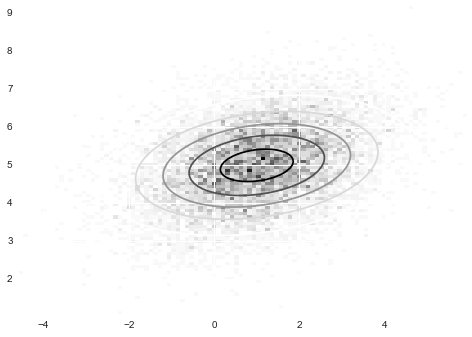

In [5]:
mu = [1, 5]
cov = [[2, 0.5], [0.5, 1]]
samples = np.random.multivariate_normal(mu, cov, size=10000)

x = np.linspace(-4, 6, 100)
y = np.linspace(0, 8, 100)
X, Y = np.meshgrid(x, y)
Z = mlab.bivariate_normal(X, Y, 2, 1, 1, 5, 0.5)

fig, ax = plt.subplots()
ax.hist2d(samples[:, 0], samples[:, 1], bins=100)
ax.contour(X, Y, Z)

### Single variable slice sampling

In [ ]:
f = ss.multivariate_normal(mu, cov).pdf

In [ ]:
x0 = 1
y0 = 1

n_samples = 10000
samples = np.zeros((n_samples, 2))
w = 0.5
p = 20

for i in xrange(n_samples):

    # sampling x
    fx = lambda x: f((x, y0))
    x1 = slice_sampler(fx, 1, x0, w, p=p, doubling=True)
    x0 = x1[0]
    samples[i, 0] = x0
    
    # sampling y
    fy = lambda y: f((x0, y))
    y1 = slice_sampler(fy, 1, y0, w, p=p, doubling=True)
    y0 = y1[0]
    samples[i, 1] = y0    
    
# do ther same for stepping out as well    

In [ ]:
#Visualization
fig, ax = plt.subplots()
ax.hist2d(samples[:, 0], samples[:, 1], bins=100)
ax.contour(X, Y, Z)
ax.set_title("slice sampling result, n_samples={}".format(n_samples))

### Hyperrectangle

In [1]:
from slice_sampler import *

In [2]:
import numpy as np
import scipy.stats as ss

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
%matplotlib inline

import seaborn as sns
sns.set()

<matplotlib.contour.QuadContourSet instance at 0x000000001F316508>

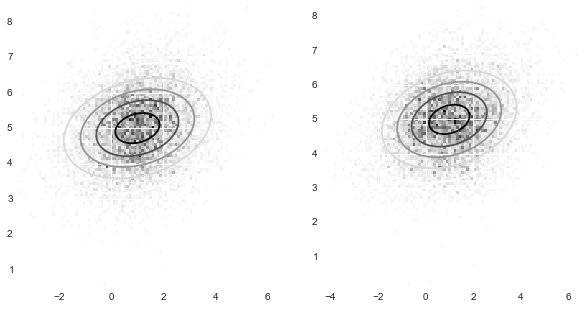

In [10]:
mu = [1, 5]
cov = [[2, 0.5], [0.5, 1]]
f = ss.multivariate_normal(mu, cov).pdf

x0 = [0, 0]
w = 1
m = 50
n_samples = 10000


samples1 = slice_sampler_stepping_out1(f, n_samples, x0, w, m)
samples2 = slice_sampler_stepping_out2(f, n_samples, x0, w, m)

#Visualization
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].hist2d(samples1[:, 0], samples1[:, 1], bins=100)
axes[0].contour(X, Y, Z)
axes[1].hist2d(samples2[:, 0], samples2[:, 1], bins=100)
axes[1].contour(X, Y, Z)

In [9]:
def slice_sampler_stepping_out1(f, n_samples, x0, w, m):
    np.random.seed(100)
    
    n_dims = len(x0)
    samples = np.zeros([n_samples, n_dims])
    
    for i in xrange(n_samples):    
        while True:
            L, R, y = I_stepping_out1(f, x0, w, m)
            x1 = np.random.uniform(L, R)

            if f(x1) > y:
                break

            mask = x1<x0
            L[mask] = x1[mask]
            mask = x1>x0
            R[mask] = x1[mask]
        x0 = x1
        samples[i] = x0
    return samples

def slice_sampler_stepping_out2(f, n_samples, x0, w, m):
    np.random.seed(100)

    
    n_dims = len(x0)
    samples = np.zeros([n_samples, n_dims])
    
    for i in xrange(n_samples):    
        while True:
            L, R, y = I_stepping_out2(f, x0, w, m)
            x1 = np.random.uniform(L, R)

            if f(x1) > y:
                break

            mask = x1<x0
            L[mask] = x1[mask]
            mask = x1>x0
            R[mask] = x1[mask]
        x0 = x1
        samples[i] = x0
    return samples

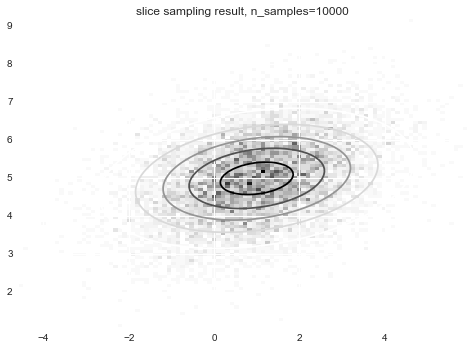

In [6]:
#Visualization
fig, ax = plt.subplots()
ax.hist2d(samples[:, 0], samples[:, 1], bins=100)
ax.contour(X, Y, Z)
ax.set_title("slice sampling result, n_samples={}".format(n_samples))

Suppose we have a two-dimensional density and we want to estimate it by slice sampling. 

$$ f(x, y) =  \frac{1}{C} e^{-\frac{(x^2 \,y^2+x^2+y^2-8x-8y)}{2}} $$
m
One way to solve this problem is deriving $p(x \mid y)$ and $p(y \mid x)$ (similar to Gibbs sampling) and then sample each dimension separatly.

$$ p(x \mid y) = g(y) e^{-\left(x-\frac{4}{(1+y^2)}\right)^{2}\frac{(1+y^2)}{2}} $$

$$ p(y \mid x) = g(x) e^{-\left(y-\frac{4}{(1+x^2)}\right)^{2}\frac{(1+x^2)}{2}} $$